In [3]:
import torch
import torch.nn as nn 
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


## **Model Architecture**

In [4]:
# Simple 3 layer covolution model 
class CNN_model(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        
        # Convolution blocks
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channel, 16, kernel_size=3, stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # NN block
        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*128, 1024),     # 32768 -> 1024
            nn.BatchNorm1d(1024),          # Add BatchNorm for regularization
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),               # Add dropout to prevent overfitting
            nn.Linear(1024, 512),          # Add an additional layer for deeper representation
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 128),           # Another layer for further abstraction
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 9)              # Output layer (9 waste categories)
        )
    def forward(self,x):
        X = self.feature_extractor(x)
        X = torch.flatten(X,1)
        X = self.fully_connected(X)
        
        return X
        
        

## **Data Loaders**

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import random

class AugmentedDataset(Dataset):
    """Dataset wrapper that applies multiple augmentations to create additional samples"""
    def __init__(self, dataset, num_augmentations=3, transform=None):
        self.dataset = dataset
        self.num_augmentations = num_augmentations
        self.transform = transform
        
        # Basic transform for converting to tensor if no transform provided
        self.basic_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Define a set of stronger augmentation transforms
        self.augmentations = [
            # Transform 1: Horizontal flip + slight rotation
            transforms.Compose([
                transforms.Resize((128,128)),
                transforms.RandomHorizontalFlip(p=1.0),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            # Transform 2: Vertical flip + color jitter
            transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.RandomVerticalFlip(p=1.0),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            # Transform 3: Random affine + color jitter
            transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            # Transform 4: Center crop + rotation
            transforms.Compose([
                transforms.Resize((150, 150)),  # Larger size for crop
                transforms.CenterCrop(128),
                transforms.RandomRotation(30),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        ]
        
    def __len__(self):
        return len(self.dataset) * (self.num_augmentations + 1)  # Original + augmentations
    
    def __getitem__(self, idx):
        # Determine which original image to use
        original_idx = idx // (self.num_augmentations + 1)
        aug_idx = idx % (self.num_augmentations + 1)
        
        # Get original image
        img, label = self.dataset[original_idx]
        
        # If aug_idx is 0, return original with basic transform
        if aug_idx == 0:
            if self.transform:
                return self.transform(img), label
            else:
                return self.basic_transform(img), label
        
        # Otherwise, apply one of the augmentations
        # Use modulo to ensure we stay within the range of available augmentations
        transform_idx = (aug_idx - 1) % len(self.augmentations)
        transform = self.augmentations[transform_idx]
        return transform(img), label

# Define standard transform for basic transformations
transform_standard = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transform for validation/test (no augmentation)
transform_val = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to the RealWaste dataset
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"  # Update if needed

# Load the original dataset without transforms (we'll apply them in the wrapper)
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Get dataset size
dataset_size = len(dataset)
print(f"Original dataset size: {dataset_size}")
print(f"Class names: {dataset.classes}")

# Calculate split sizes (70% train, 15% validation, 15% test)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create indices for the splits
indices = list(range(dataset_size))
random.seed(42)  # For reproducibility
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create custom datasets with appropriate transforms and indices
class CustomSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label
        
    def __len__(self):
        return len(self.indices)

# Create base dataset splits
train_subset = CustomSubset(dataset, train_indices, transform=None)  # Apply transformation later
val_dataset = CustomSubset(dataset, val_indices, transform=transform_val)
test_dataset = CustomSubset(dataset, test_indices, transform=transform_val)

# Augment only the training set (4 augmentations per image + original)
train_dataset = AugmentedDataset(train_subset, num_augmentations=2, transform=transform_standard)

# Create data loaders
batch_size = 64  # Smaller batch size for larger images
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Print split information
original_train_size = len(train_subset)
augmented_train_size = len(train_dataset)
print(f"Original training samples: {original_train_size}")
print(f"Augmented training samples: {augmented_train_size} (×{augmented_train_size / original_train_size:.1f})")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Original dataset size: 4752
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Original training samples: 3326
Augmented training samples: 9978 (×3.0)
Validation samples: 712
Test samples: 714


Checking training data...
Batch shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


Has NaN: False
Has Inf: False
Min value: -2.1179039478302
Max value: 2.5702831745147705

Checking validation data...
Batch shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


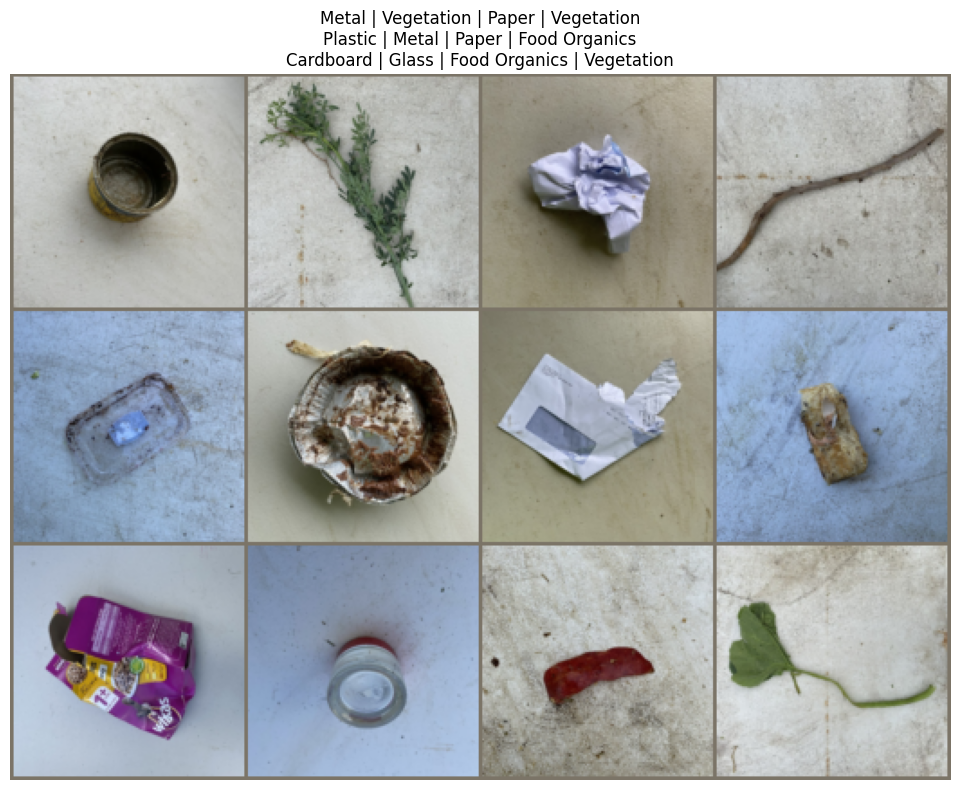

Has NaN: False
Has Inf: False
Min value: -2.1007792949676514
Max value: 2.6051416397094727


True

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def show_batch(dataloader, classes, num_images=12):
    """
    Display a batch of images with their labels from a dataloader
    
    Args:
        dataloader: PyTorch dataloader to get images from
        classes: List of class names
        num_images: Maximum number of images to display
    """
    # Get a batch of training data
    images, labels = next(iter(dataloader))
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Convert images back to a displayable format
    images = images[:num_images]  # Take only the first num_images
    labels = labels[:num_images]
    
    # Unnormalize the images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Create a grid of images
    img_grid = make_grid(images, nrow=4)
    img_grid = img_grid.numpy().transpose((1, 2, 0))
    
    # Unnormalize
    img_grid = std * img_grid + mean
    img_grid = np.clip(img_grid, 0, 1)
    
    # Display the images
    plt.figure(figsize=(12, 8))
    plt.imshow(img_grid)
    plt.axis('off')
    
    # Add labels as titles - fix the list issue
    # Convert each label tensor to its corresponding class name
    title_list = []
    for i in range(len(labels)):
        # Make sure to get the integer value from the tensor
        class_idx = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        title_list.append(f"{classes[class_idx]}")
    
    # Group titles into rows of 4 for display
    title_rows = []
    for i in range(0, len(title_list), 4):
        row = title_list[i:i+4]
        title_rows.append(" | ".join(row))
    
    # Join all rows with newlines
    title = "\n".join(title_rows)
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Check if any of the tensor values are NaN or Inf
    print(f"Has NaN: {torch.isnan(images).any()}")
    print(f"Has Inf: {torch.isinf(images).any()}")
    print(f"Min value: {images.min()}")
    print(f"Max value: {images.max()}")
    
    return True

# Test the train loader
print("Checking training data...")
show_batch(train_loader, dataset.classes)

# Test the validation loader
print("\nChecking validation data...")
show_batch(val_loader, dataset.classes)

## **Training**

In [7]:
import time 
import os
from tqdm import tqdm

def Train(device, model, epochs, save_dir="/kaggle/working/models", batch_size=None):
    
    os.makedirs(save_dir, exist_ok=True)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-3)
    # Optional: Add learning rate scheduler for better convergence
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    EPOCHS = epochs
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    best_val_loss = float('inf')
    best_model_path = os.path.join(save_dir, "best_model.pth")
    last_model_path = os.path.join(save_dir, "last_model.pth")

    for epoch in range(EPOCHS):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        print(f"Epoch {epoch+1}/{EPOCHS} [Train]")
        for images, labels in tqdm(train_loader):
            # Move data to device
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # Zero gradients
            optimizer.zero_grad(set_to_none=True)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            # Track metrics (using your approach)
            train_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_loss /= len(train_dataset)
        train_acc = train_correct / len(train_dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        print(f"Epoch {epoch+1}/{EPOCHS} [Val]")
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                # Move data to device
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                # Track metrics
                val_loss += loss.item() * images.size(0)
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        val_loss /= len(val_dataset)
        val_acc = val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Save the latest model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses,
            'train_acc': train_accs,
            'val_loss': val_losses,
            'val_acc': val_accs,
            'current_lr': optimizer.param_groups[0]['lr']
        }, last_model_path)
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_losses,
                'train_acc': train_accs,
                'val_loss': val_losses,
                'val_acc': val_accs,
                'best_val_loss': best_val_loss,
                'current_lr': optimizer.param_groups[0]['lr']
            }, best_model_path)
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
        
        # Calculate time taken for epoch
        epoch_time = time.time() - start_time
        
        # Print epoch summary (using your format)
        print(f'Epoch: {epoch+1}/{EPOCHS}, '
              f'Time: {epoch_time:.2f}s, '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
    print(f"Best model saved to {best_model_path}")
    print(f"Last model saved to {last_model_path}")
    
    # Return training history
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }
    
    return history, model

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
model = CNN_model(in_channel=3).to(device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 [Train]


100%|██████████| 156/156 [00:24<00:00,  6.45it/s]


Epoch 1/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.07it/s]


Saved new best model with validation loss: 1.1179
Epoch: 1/30, Time: 27.93s, Train Loss: 1.4359, Train Acc: 0.4742, Val Loss: 1.1179, Val Acc: 0.5955, LR: 0.002000
Epoch 2/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.82it/s]


Epoch 2/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


Saved new best model with validation loss: 0.9269
Epoch: 2/30, Time: 27.00s, Train Loss: 1.0900, Train Acc: 0.6045, Val Loss: 0.9269, Val Acc: 0.6461, LR: 0.002000
Epoch 3/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.97it/s]


Epoch 3/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.15it/s]


Saved new best model with validation loss: 0.9015
Epoch: 3/30, Time: 26.50s, Train Loss: 0.9462, Train Acc: 0.6564, Val Loss: 0.9015, Val Acc: 0.6573, LR: 0.002000
Epoch 4/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.93it/s]


Epoch 4/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


Saved new best model with validation loss: 0.7731
Epoch: 4/30, Time: 26.64s, Train Loss: 0.8233, Train Acc: 0.7011, Val Loss: 0.7731, Val Acc: 0.7247, LR: 0.002000
Epoch 5/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.93it/s]


Epoch 5/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.19it/s]


Epoch: 5/30, Time: 25.40s, Train Loss: 0.6999, Train Acc: 0.7471, Val Loss: 0.8062, Val Acc: 0.7008, LR: 0.002000
Epoch 6/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.89it/s]


Epoch 6/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.02it/s]


Epoch: 6/30, Time: 25.58s, Train Loss: 0.6366, Train Acc: 0.7750, Val Loss: 0.8196, Val Acc: 0.7303, LR: 0.002000
Epoch 7/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.94it/s]


Epoch 7/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.08it/s]


Epoch: 7/30, Time: 25.41s, Train Loss: 0.5373, Train Acc: 0.8093, Val Loss: 1.0747, Val Acc: 0.6671, LR: 0.002000
Epoch 8/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.93it/s]


Epoch 8/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


Epoch: 8/30, Time: 25.40s, Train Loss: 0.4852, Train Acc: 0.8256, Val Loss: 0.9639, Val Acc: 0.6685, LR: 0.001000
Epoch 9/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.95it/s]


Epoch 9/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.37it/s]


Saved new best model with validation loss: 0.6356
Epoch: 9/30, Time: 26.59s, Train Loss: 0.3492, Train Acc: 0.8772, Val Loss: 0.6356, Val Acc: 0.7921, LR: 0.001000
Epoch 10/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.97it/s]


Epoch 10/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.22it/s]


Epoch: 10/30, Time: 25.28s, Train Loss: 0.2801, Train Acc: 0.8994, Val Loss: 0.7028, Val Acc: 0.7865, LR: 0.001000
Epoch 11/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.84it/s]


Epoch 11/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.28it/s]


Epoch: 11/30, Time: 25.70s, Train Loss: 0.2506, Train Acc: 0.9122, Val Loss: 0.6648, Val Acc: 0.7893, LR: 0.001000
Epoch 12/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.92it/s]


Epoch 12/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.34it/s]


Epoch: 12/30, Time: 25.42s, Train Loss: 0.2170, Train Acc: 0.9280, Val Loss: 0.7060, Val Acc: 0.7809, LR: 0.001000
Epoch 13/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.96it/s]


Epoch 13/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.92it/s]


Epoch: 13/30, Time: 25.40s, Train Loss: 0.1998, Train Acc: 0.9309, Val Loss: 0.7307, Val Acc: 0.7992, LR: 0.000500
Epoch 14/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.89it/s]


Epoch 14/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


Epoch: 14/30, Time: 25.52s, Train Loss: 0.1492, Train Acc: 0.9512, Val Loss: 0.7166, Val Acc: 0.8048, LR: 0.000500
Epoch 15/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.98it/s]


Epoch 15/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.01it/s]


Epoch: 15/30, Time: 25.31s, Train Loss: 0.1079, Train Acc: 0.9657, Val Loss: 0.7447, Val Acc: 0.7963, LR: 0.000500
Epoch 16/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.94it/s]


Epoch 16/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.26it/s]


Epoch: 16/30, Time: 25.37s, Train Loss: 0.1051, Train Acc: 0.9631, Val Loss: 0.7324, Val Acc: 0.7935, LR: 0.000500
Epoch 17/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.94it/s]


Epoch 17/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


Epoch: 17/30, Time: 25.34s, Train Loss: 0.0908, Train Acc: 0.9708, Val Loss: 0.7093, Val Acc: 0.8118, LR: 0.000250
Epoch 18/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.91it/s]


Epoch 18/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.15it/s]


Epoch: 18/30, Time: 25.49s, Train Loss: 0.0668, Train Acc: 0.9786, Val Loss: 0.7342, Val Acc: 0.8216, LR: 0.000250
Epoch 19/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.96it/s]


Epoch 19/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


Epoch: 19/30, Time: 25.31s, Train Loss: 0.0599, Train Acc: 0.9820, Val Loss: 0.7263, Val Acc: 0.8160, LR: 0.000250
Epoch 20/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.95it/s]


Epoch 20/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.00it/s]


Epoch: 20/30, Time: 25.40s, Train Loss: 0.0594, Train Acc: 0.9809, Val Loss: 0.6917, Val Acc: 0.8188, LR: 0.000250
Epoch 21/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.90it/s]


Epoch 21/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.33it/s]


Epoch: 21/30, Time: 25.47s, Train Loss: 0.0547, Train Acc: 0.9836, Val Loss: 0.7301, Val Acc: 0.8287, LR: 0.000125
Epoch 22/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  7.03it/s]


Epoch 22/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.34it/s]


Epoch: 22/30, Time: 25.08s, Train Loss: 0.0437, Train Acc: 0.9872, Val Loss: 0.7137, Val Acc: 0.8258, LR: 0.000125
Epoch 23/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.94it/s]


Epoch 23/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


Epoch: 23/30, Time: 25.40s, Train Loss: 0.0450, Train Acc: 0.9871, Val Loss: 0.7242, Val Acc: 0.8174, LR: 0.000125
Epoch 24/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.88it/s]


Epoch 24/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.19it/s]


Epoch: 24/30, Time: 25.57s, Train Loss: 0.0401, Train Acc: 0.9877, Val Loss: 0.7171, Val Acc: 0.8230, LR: 0.000125
Epoch 25/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.95it/s]


Epoch 25/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.09it/s]


Epoch: 25/30, Time: 25.37s, Train Loss: 0.0371, Train Acc: 0.9897, Val Loss: 0.7498, Val Acc: 0.8160, LR: 0.000063
Epoch 26/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  7.02it/s]


Epoch 26/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.12it/s]


Epoch: 26/30, Time: 25.15s, Train Loss: 0.0407, Train Acc: 0.9886, Val Loss: 0.7498, Val Acc: 0.8188, LR: 0.000063
Epoch 27/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.94it/s]


Epoch 27/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


Epoch: 27/30, Time: 25.31s, Train Loss: 0.0363, Train Acc: 0.9898, Val Loss: 0.7420, Val Acc: 0.8118, LR: 0.000063
Epoch 28/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.96it/s]


Epoch 28/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.21it/s]


Epoch: 28/30, Time: 25.30s, Train Loss: 0.0333, Train Acc: 0.9906, Val Loss: 0.7534, Val Acc: 0.8244, LR: 0.000063
Epoch 29/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  7.03it/s]


Epoch 29/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.24it/s]


Epoch: 29/30, Time: 25.07s, Train Loss: 0.0326, Train Acc: 0.9902, Val Loss: 0.7281, Val Acc: 0.8202, LR: 0.000031
Epoch 30/30 [Train]


100%|██████████| 156/156 [00:22<00:00,  6.90it/s]


Epoch 30/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.27it/s]


Epoch: 30/30, Time: 25.50s, Train Loss: 0.0332, Train Acc: 0.9904, Val Loss: 0.7397, Val Acc: 0.8188, LR: 0.000031
Training completed. Best validation loss: 0.6356
Best model saved to models/best_model.pth
Last model saved to models/last_model.pth


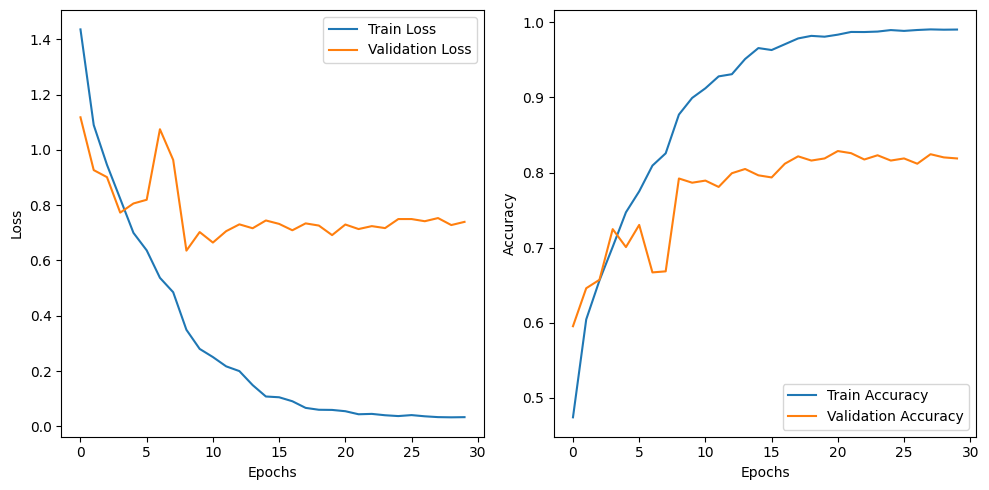

In [10]:
history, trained_model = Train(device, model, epochs=30, save_dir="models")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()